In [27]:
import trimesh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
data_dir = '/Users/madelineloui/Documents/MIT/Classes/EC.712/scanning/data'
df = pd.read_csv(f'{data_dir}/scan_results_trimesh.csv')
print(len(df))
df.head()

8


,Unnamed: 0,Room,Center/close to wall (within 5 ft),Technique,Filename,Sq Ft,Scanning Time (s),Rendering Time (s),Raw Data File Size (MB),File Size (MB) without raw data,Visual Quality (Score 1-5),Vertex count,Triangle count,Mesh area,Vertex density,Triangle density
0,0,Closet,Center,Lidar (speed),closet_center_lidar_SPEED.glb,NaN,91,19,120.8,4.4,NaN,39993,52885,49.939354,800.831352,1058.984473
1,1,Closet,Center,Lidar (area),closet_center_lidar_AREA.glb,NaN,91,39,120.8,14.5,NaN,132666,179096,50.677093,2617.869206,3534.062256
2,2,Closet,Close to wall,Lidar (speed),closet_close_to_wall_lidar_SPEED.glb,NaN,620,70,732.3,4.9,NaN,36817,42949,69.653172,528.576069,616.612261
3,3,Closet,Close to wall,Lidar (area),closet_close_to_wall_lidar_AREA.glb,NaN,620,158,732.3,15.7,NaN,169823,209804,73.251163,2318.365917,2864.172950
4,4,Conference,Center,Lidar (speed),conference_room_center_lidar_SPEED.glb,NaN,106,21,140.5,3.8,NaN,28748,41742,127.508934,225.458711,327.365296


In [37]:
def get_stats(geom):
    total_vertices = len(geom.vertices)
    total_triangles = len(geom.faces)
    area = geom.area
    v_to_a = total_vertices / area
    t_to_a = total_triangles / area
    
    return {
        "vertices": total_vertices,
        "triangles": total_triangles,
        "area": area,
        "v_to_a": v_to_a,
        "t_to_a": t_to_a,
    }

def store_stats(df, filename, prefix, stats_dict):
    """Write stats into df for the row with this filename, using prefix for column names."""
    row_mask = df["Filename"] == filename
    for key, value in stats_dict.items():
        col = f"{prefix}_{key}"  # e.g. 'holes_vertices', 'normals_area'
        df.loc[row_mask, col] = value
        
for filename in df['Filename'].tolist():
    print(f'Processing {filename}...')
    scene = trimesh.load(f'{data_dir}/scans/{filename}', force='scene')
    geom = scene.to_geometry()

    # Work on a copy so original stays unchanged
    geom_repaired = geom.copy()

    # Apply all repairs in sequence
    trimesh.repair.fill_holes(geom_repaired)
    trimesh.repair.fix_inversion(geom_repaired)
    trimesh.repair.fix_normals(geom_repaired)
    trimesh.repair.fix_winding(geom_repaired)

    # Optionally: measure how many broken faces remain
    broken = trimesh.repair.broken_faces(geom_repaired)

    # Get stats after all repairs
    repair_stats = get_stats(geom_repaired)
    repair_stats["broken_faces_count"] = len(broken)

    # Store as repair_* columns, e.g. repair_vertices, repair_area, ...
    store_stats(df, filename, "repair", repair_stats)


Processing closet_center_lidar_SPEED.glb...
Processing closet_center_lidar_AREA.glb...
Processing closet_close_to_wall_lidar_SPEED.glb...
Processing closet_close_to_wall_lidar_AREA.glb...
Processing conference_room_center_lidar_SPEED.glb...
Processing conference_room_center_lidar_AREA.glb...
Processing conference_room_close_to_wall_lidar_SPEED.glb...
Processing conference_room_close_to_wall_lidar_AREA.glb...


In [38]:
df.head()

,Unnamed: 0,Room,Center/close to wall (within 5 ft),Technique,Filename,Sq Ft,Scanning Time (s),Rendering Time (s),Raw Data File Size (MB),File Size (MB) without raw data,...,Triangle count,Mesh area,Vertex density,Triangle density,repair_vertices,repair_triangles,repair_area,repair_v_to_a,repair_t_to_a,repair_broken_faces_count
0,0,Closet,Center,Lidar (speed),closet_center_lidar_SPEED.glb,NaN,91,19,120.8,4.4,...,52885,49.939354,800.831352,1058.984473,39993.0,54194.0,50.562094,790.968029,1071.830604,20183.0
1,1,Closet,Center,Lidar (area),closet_center_lidar_AREA.glb,NaN,91,39,120.8,14.5,...,179096,50.677093,2617.869206,3534.062256,132666.0,183900.0,51.261678,2588.015180,3587.475251,64569.0
2,2,Closet,Close to wall,Lidar (speed),closet_close_to_wall_lidar_SPEED.glb,NaN,620,70,732.3,4.9,...,42949,69.653172,528.576069,616.612261,36817.0,44534.0,71.382231,515.772614,623.880750,21738.0
3,3,Closet,Close to wall,Lidar (area),closet_close_to_wall_lidar_AREA.glb,NaN,620,158,732.3,15.7,...,209804,73.251163,2318.365917,2864.172950,169823.0,216450.0,74.278153,2286.311572,2914.046623,94041.0
4,4,Conference,Center,Lidar (speed),conference_room_center_lidar_SPEED.glb,NaN,106,21,140.5,3.8,...,41742,127.508934,225.458711,327.365296,28748.0,42313.0,128.279449,224.104486,329.850185,12380.0


In [39]:
df = df.rename(columns={
    "Vertex count": "vertices",
    "Triangle count": "triangles",
    "Mesh area": "area",
    "Vertex density": "v_to_a",
    "Triangle density": "t_to_a"
})

In [40]:
df = df.drop(columns=["Unnamed: 0"])
df.to_csv(f'{data_dir}/all_repairs.csv', index=False)

### Visualize

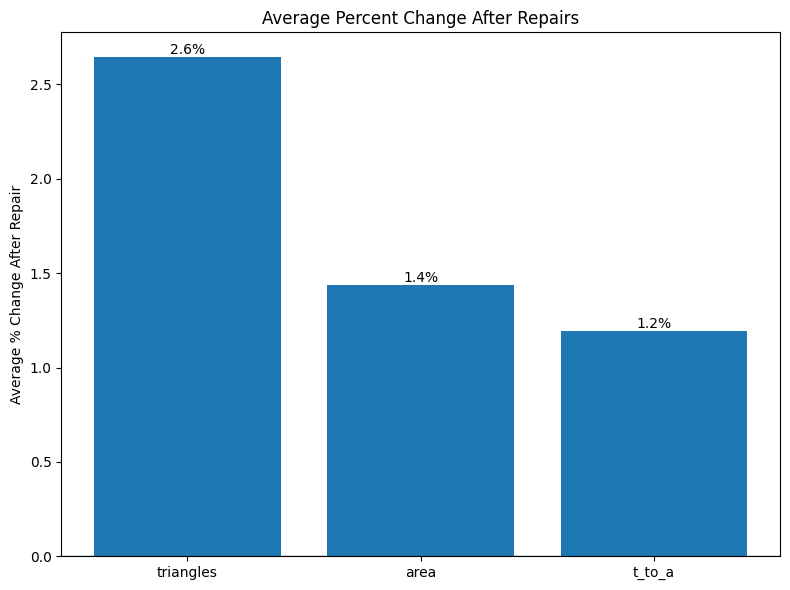

In [52]:
# Load your data
df = pd.read_csv(f"{data_dir}/all_repairs.csv")  # adjust path if needed

# Metrics to compare
metrics = ["triangles", "area", "t_to_a"] # remove vertices since it only changes faces

avg_pct_changes = {}

for m in metrics:
    before = df[m].astype(float)
    after = df[f"repair_{m}"].astype(float)

    # Avoid division by zero
    before_safe = before.replace(0, np.nan)

    pct_change = (after - before_safe) / before_safe * 100.0
    avg_pct_changes[m] = pct_change.mean(skipna=True)

# Prepare data for plotting
labels = list(avg_pct_changes.keys())
values = [avg_pct_changes[m] for m in labels]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values)

plt.ylabel("Average % Change After Repair")
plt.title("Average Percent Change After Repairs")
plt.axhline(0, linewidth=1)

# Optional: add value labels on top of each bar
for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{val:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

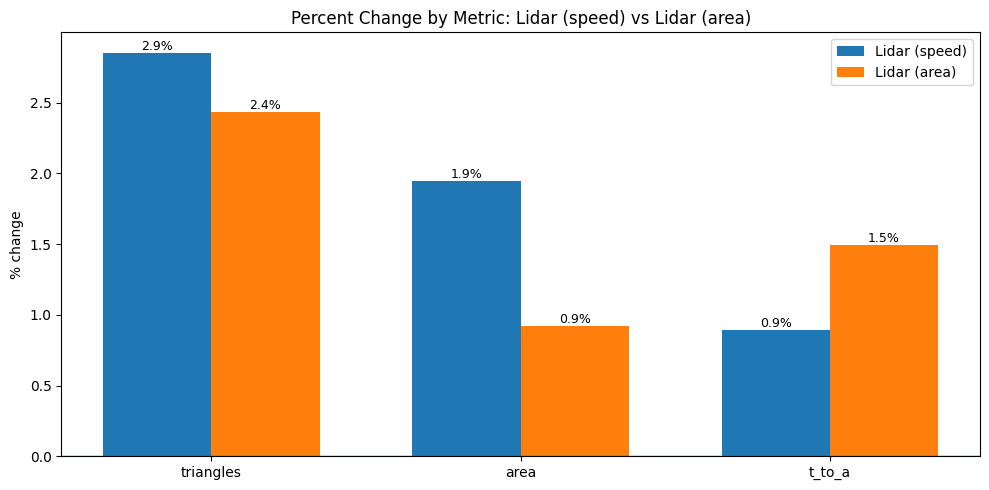

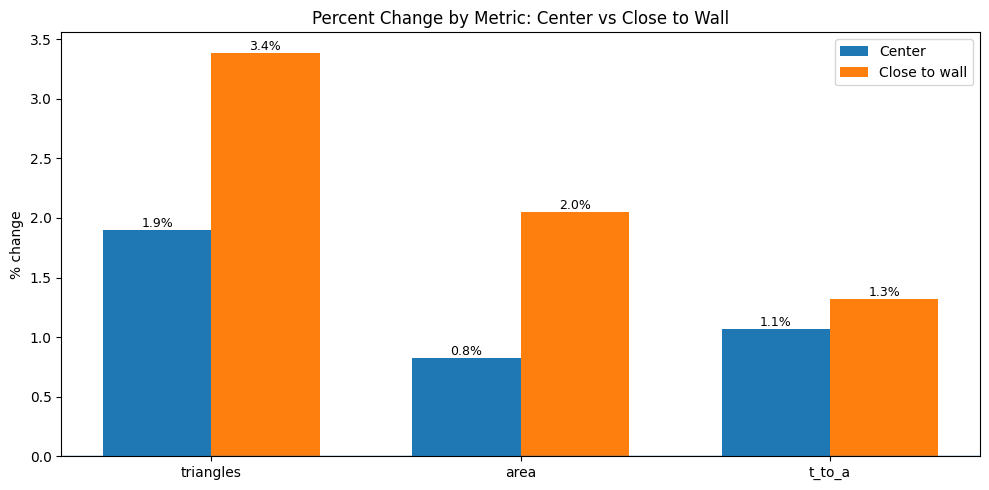

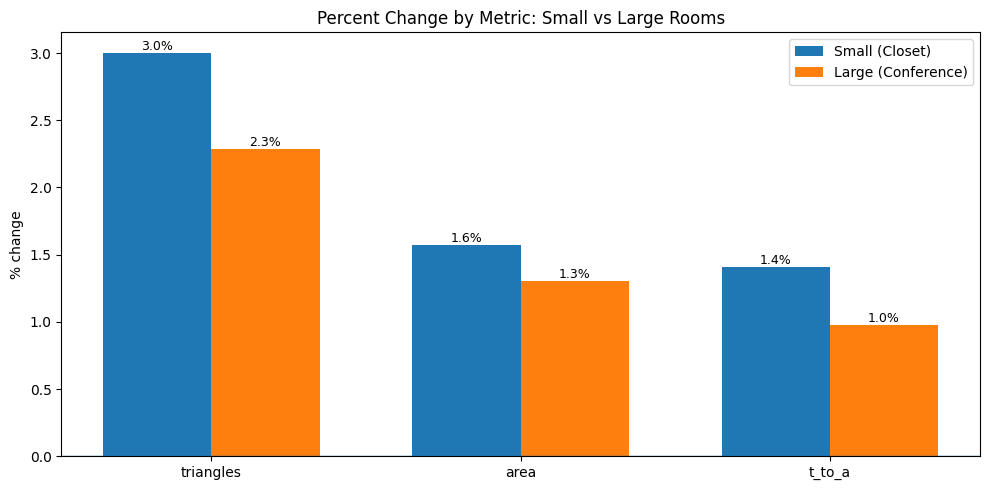

In [53]:
# % change columns
for m in metrics:
    df[f"pct_{m}"] = (df[f"repair_{m}"] - df[m]) / df[m].replace(0, np.nan) * 100

pct_cols = [f"pct_{m}" for m in metrics]

def plot_two_group(df, group_col, group_vals, group_labels, title):
    g = df[df[group_col].isin(group_vals)].groupby(group_col)[pct_cols].mean()

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(x - width/2, g.loc[group_vals[0]], width=width, label=group_labels[0], color="C0")
    bars2 = ax.bar(x + width/2, g.loc[group_vals[1]], width=width, label=group_labels[1], color="C1")

    # Value labels
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f"{height:.1f}%", ha="center", va="bottom", fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f"{height:.1f}%", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylabel("% change")
    ax.set_title(title)
    ax.axhline(0, lw=1)
    ax.legend()
    plt.tight_layout()
    plt.show()

# 1) Lidar speed vs area
df["tech_group"] = np.where(df["Technique"] == "Lidar (speed)", "speed", "area")
plot_two_group(
    df,
    group_col="tech_group",
    group_vals=["speed", "area"],
    group_labels=["Lidar (speed)", "Lidar (area)"],
    title="Percent Change by Metric: Lidar (speed) vs Lidar (area)"
)

# 2) Center vs close to wall
pos_col = "Center/close to wall (within 5 ft)"
plot_two_group(
    df,
    group_col=pos_col,
    group_vals=["Center", "Close to wall"],
    group_labels=["Center", "Close to wall"],
    title="Percent Change by Metric: Center vs Close to Wall"
)

# 3) Small vs large room
df["room_group"] = np.where(df["Room"] == "Closet", "small",
                     np.where(df["Room"] == "Conference", "large", "other"))
df_rooms = df[df["room_group"].isin(["small", "large"])]

plot_two_group(
    df_rooms,
    group_col="room_group",
    group_vals=["small", "large"],
    group_labels=["Small (Closet)", "Large (Conference)"],
    title="Percent Change by Metric: Small vs Large Rooms"
)


### Old

In [19]:
def get_stats(geom):
    total_vertices = len(geom.vertices)
    total_triangles = len(geom.faces)
    area = geom.area
    v_to_a = total_vertices/area
    t_to_a = total_triangles/area
    
    print("Vertex count:", total_vertices)
    print("Triangle count:", total_triangles)
    print("Mesh area:", area)
    print(f"Vertices per area: {v_to_a:.2f}")
    print(f"Triangles per area: {t_to_a:.2f}")
    print()

In [20]:
for filename in df['Filename'].to_list():
    print(f'Processing {filename}...')
    scene = trimesh.load(f'{data_dir}/scans/{filename}', force='scene')
    geom = scene.to_geometry()
    get_stats(geom)

    # Repair holes
    geom_copy = geom.copy()
    trimesh.repair.fill_holes(geom_copy)
    get_stats(geom_copy)

    # Fix inversions
    geom_copy = geom.copy()
    trimesh.repair.fix_inversion(geom_copy)
    get_stats(geom_copy)

    # Fix normals
    geom_copy = geom.copy()
    trimesh.repair.fix_normals(geom_copy)
    get_stats(geom_copy)

    # Fix winding
    geom_copy = geom.copy()
    trimesh.repair.fix_winding(geom_copy)
    get_stats(geom_copy)

    # Fix broken faces
    geom_copy = geom.copy()
    broken = trimesh.repair.broken_faces(geom_copy)
    print(f"Broken faces: {len(broken)}")
    get_stats(geom_copy)

Processing closet_center_lidar_SPEED.glb...
Vertex count: 39993
Triangle count: 52885
Mesh area: 49.93935354888803
Vertices per area: 800.83
Triangles per area: 1058.98

Vertex count: 39993
Triangle count: 54194
Mesh area: 50.56209421296419
Vertices per area: 790.97
Triangles per area: 1071.83

Vertex count: 39993
Triangle count: 52885
Mesh area: 49.93935354888803
Vertices per area: 800.83
Triangles per area: 1058.98

Vertex count: 39993
Triangle count: 52885
Mesh area: 49.93935354888803
Vertices per area: 800.83
Triangles per area: 1058.98

Vertex count: 39993
Triangle count: 52885
Mesh area: 49.93935354888803
Vertices per area: 800.83
Triangles per area: 1058.98

Broken faces: 18628
Vertex count: 39993
Triangle count: 52885
Mesh area: 49.93935354888803
Vertices per area: 800.83
Triangles per area: 1058.98

Processing closet_center_lidar_AREA.glb...
Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06

Vertex c

### Test

In [2]:
scene = trimesh.load("/Users/madelineloui/Documents/MIT/Classes/EC.712/scanning/data/scans/closet_center_lidar_AREA.glb", force='scene')
geom = scene.to_geometry()

In [3]:
def get_stats(geom):
    total_vertices = len(geom.vertices)
    total_triangles = len(geom.faces)
    area = geom.area
    v_to_a = total_vertices/area
    t_to_a = total_triangles/area
    
    print("Vertex count:", total_vertices)
    print("Triangle count:", total_triangles)
    print("Mesh area:", area)
    print(f"Vertices per area: {v_to_a:.2f}")
    print(f"Triangles per area: {t_to_a:.2f}")
    print()

In [4]:
# Original
get_stats(geom)
#geom.show()

Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06



In [5]:
# Fill holes
geom_copy = geom.copy()
trimesh.repair.fill_holes(geom_copy)
get_stats(geom_copy)
#geom_copy.show()

Vertex count: 132666
Triangle count: 183900
Mesh area: 51.26167768252798
Vertices per area: 2588.02
Triangles per area: 3587.48



In [6]:
# Fix inversion
geom_copy = geom.copy()
trimesh.repair.fix_inversion(geom_copy)
get_stats(geom_copy)
#geom_copy.show()

Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06



In [7]:
# Fix normals
geom_copy = geom.copy()
trimesh.repair.fix_normals(geom_copy)
get_stats(geom_copy)
#geom_copy.show()

Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06



In [8]:
# Fix winding
geom_copy = geom.copy()
trimesh.repair.fix_winding(geom_copy)
get_stats(geom_copy)
#geom_copy.show()

Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06



In [9]:
# Fix broken faces
geom_copy = geom.copy()
broken = trimesh.repair.broken_faces(geom_copy)
print(f"Broken faces: {len(broken)}")
get_stats(geom_copy)
#geom_copy.show()

Broken faces: 58925
Vertex count: 132666
Triangle count: 179096
Mesh area: 50.67709253838293
Vertices per area: 2617.87
Triangles per area: 3534.06

